# CS6700 : Programming Assignment - 3
Students:
- Janmenjaya Panda (ME20B087)
- Nishant Sahoo (ME20B122)

In [1]:
# 1 Hierarchical Reinforcement Learning
# For this assignment, we will be referring to Sutton, Precup and Singh’s 1999 paper, ‘Between MDPs and semi-MDPs : A Framework for Temporal Abstraction in Reinforcement
# good reference leading up to the understanding and implementation of SMDP Q-learning.
# Section 3 of the paper talks about SMDP planning and is necessary to build intuition to
# solve this assignment. We will be working with a simple taxi domain environment (explained
# in the next section). Your tasks are to implement 1-step SMDP Q-Learning and intraoption Q-Learning on this environment.
# 2 Environment Description
# The environment for this task is the taxi domain, illustrated in Fig. 1. It is a 5x5 matrix,
# where each cell is a position your taxi can stay at. There is a single passenger who can
# be either picked up or dropped off, or is being transported. There are four designated
# locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the
# episode starts, the taxi starts off at a random square and the passenger is at a random
# location. The taxi drives to the passenger’s location, picks up the passenger, drives to the
# passenger’s destination (another one of the four specified locations), and then drops off the
# passenger. Once the passenger is dropped off, the episode ends.
# There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the
# passenger (including the case when the passenger is in the taxi), and 4 destination locations.
# Note that there are 400 states that can actually be reached during an episode. The missing
# states correspond to situations in which the passenger is at the same location as their
# destination, as this typically signals the end of an episode. Four additional states can be
# observed right after a successful episodes, when both the passenger and the taxi are at the
# destination. This gives a total of 404 reachable discrete states.
# Passenger locations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue); 4: in taxi
# Destinations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue)
# Rewards:
# • -1 per step unless other reward is triggered.
# • +20 delivering passenger.
# • -10 executing ”pickup” and ”drop-off” actions illegally.
# The discount factor is taken to be γ = 0.9.
# 1
# Learning’. Please read the paper upto and including Section 3, it is self explanatory and a
# Programming Assignment 3
# April 6, 2024
# CS6700: Reinforcement Learning
# Figure 1: Taxi Domain
# 3 Actions and Options
# Actions: There are 6 discrete deterministic actions: 0: move south; 1: move north; 2:
# move east; 3: move west; 4: pick passenger up; and 5: drop passenger off.
# Options: Options to move the taxi to each of the four designated locations, executable
# when the taxi is not already there.
# 4 Tasks
# First, implement the single step SMDP Q-learning for solving the taxi problem. A rough
# sketch of the algorithm is as follows: Given the set of options,
# • Execute the current selected option to termination (e.g. use epsilon greedy Q(s, o)).
# • Computer r(s, o).
# • Update Q(st
# , o).
# Second, implement intra-option Q-Learning on the same environment.
# For each algorithm, do the following (only for the configuration with the best hyperparameters):
# 1. Plot reward curves and visualize the learned Q-values.
# 2. Provide a written description of the policies learnt and your reasoning behind why
# the respective algorithm learns the policy.
# 2
# You will be experimenting with Gymnasium Gym’s Taxi-v3 environment.
# 3. Is there an alternate set of options that you can use to solve this problem, such that
# this set and the given options to move the taxi are mutually exclusive? If so, run
# both algorithms with this alternate set of options and compare performance with the
# algorithms run on the options to move the taxi.
# Finally, provide a comparison between the SMDP Q-Learning and intra-option Q-Learning
# algorithms. Do you observe any improvement with intra-option Q-Learning? If so, describe
# why this happens as well. Please make sure that all descriptions are brief and to the point.


In [2]:
# Importing Libraries
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import random
import time
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\win32\lib\pywintypes.py:51: DeprecationWarning: getargs: The 'u' format is deprecated. Use 'U' instead.
  found = _win32sysloader.GetModuleFilename(filename)


In [3]:
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [4]:
gamma = 0.9 # Discount Factor

# Defining the Environment
# env = gym.make("Taxi-v3", render_mode="rgb_array")
env = gym.make("Taxi-v3")
# render modes : human, rgb_array, ansi
env.reset()
# env.render()

print("Current State : ", env.s)

# Print number of states and actions
print("Number of States : ", env.observation_space.n)
print("Number of Actions : ", env.action_space.n)

actions = {0 : "South", 1 : "North", 2 : "East", 3 : "West", 4 : "Pickup", 5 : "Dropoff"}

next_state, reward, done, info = env.step(1)
print("Action : ", actions[1])
print("Next State : ", next_state)
print("Reward : ", reward)
print("Done : ", done)
print("Info : ", info)

Current State :  154
Number of States :  500
Number of Actions :  6
Action :  North
Next State :  54
Reward :  -1
Done :  False
Info :  {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)}


In [5]:
def decode_state(state):
    row, col, _, _ = env.decode(state)
    return row, col

dest_loc = {"R": [0,0], "G": [0,4], "Y": [4,0], "B": [4,3]}
loc_idx = {"R": 0, "G": 1, "Y": 2, "B": 3, "in_taxi": 4}


In [6]:
def plot_Q(Q, title):
        optimal_action_grid = np.zeros((5, 5)) # stores the optimal action taken for each cell for all the states that have cell as taxi position
        # eg: [0,0] has states from 0-20 ; [0,1] has states from 21-40 and so on
        Q_grid = np.ones((5, 5)) * -1000 # stores the max Q value for each cell for all the states that have cell as taxi position
        state = 0
        while state < 500:
            row, col = decode_state(state)
            Q_grid[row, col] = np.max(Q[state])
            optimal_action_grid[row, col] = np.argmax(Q[state])
            for i in range(20):
                if Q_grid[row, col] < np.max(Q[state + i]):
                    Q_grid[row, col] = np.max(Q[state + i])
                    optimal_action_grid[row, col] = np.argmax(Q[state + i])
            state += 20

        plt.figure(figsize=(10, 10))
        plt.imshow(Q_grid, cmap='coolwarm')

        # Add annotations
        for i in range(5):
            for j in range(5):
                action = optimal_action_grid[i, j]
                if action == 0: # put down arrow
                    plt.text(j, i, u'\u2193', color='black', fontsize=20, ha='center', va='center')
                elif action == 1: # put up arrow
                    plt.text(j, i, u'\u2191', color='black', fontsize=20, ha='center', va='center')
                elif action == 2: # put right arrow
                    plt.text(j, i, u'\u2192', color='black', fontsize=20, ha='center', va='center')
                elif action == 3: # put left arrow
                    plt.text(j, i, u'\u2190', color='black', fontsize=20, ha='center', va='center')
                elif action == 4: # put Pick
                    plt.text(j, i, "Pick", color='black', fontsize=20, ha='center', va='center')
                elif action == 5: # put Drop
                    plt.text(j, i, "Drop", color='black', fontsize=20, ha='center', va='center')

        plt.axhline(y=-0.5, color='black', linewidth=3)
        plt.axhline(y=4.5, color='black', linewidth=3)
        plt.axvline(x=-0.5, color='black', linewidth=3)
        plt.axvline(x=4.5, color='black', linewidth=3)

        # Add horizontal grid lines
        for i in range(6):
            plt.axhline(y=i-0.5, color='black', linewidth=1)

        # Add vertical grid lines
        for i in range(6):
            plt.axvline(x=i-0.5, color='black', linewidth=1)

        plt.axvline(x=1.5, ymin=0.8, ymax=1, color='black', linewidth=3)
        plt.axvline(x=0.5, ymin=0, ymax=0.4, color='black', linewidth=3)
        plt.axvline(x=2.5, ymin=0, ymax=0.4, color='black', linewidth=3)

        plt.colorbar()
        plt.title(title)
        plt.show()

In [99]:
class Plot():
    def __init__(self, env, rewards, Q, name):
        self.env = env
        self.rewards = rewards
        self.Q = Q
        self.name = name

    def visualize_taxi_env(self):
        grid = np.ones((5, 5, 3)) # 5x5 grid with 3 channels for RGB

        taxi_row, taxi_col, pass_idx, dest_idx = self.env.decode(self.env.s)

        grid[0,0] = [1, 0, 0] # Red
        grid[0,4] = [0, 1, 0] # Green
        grid[4,0] = [1, 1, 0] # Yellow
        grid[4,3] = [0, 0, 1] # Blue

        plt.figure(figsize=(10, 10))
        plt.imshow(grid)

        # Add horizontal grid lines
        for i in range(6):
            plt.axhline(y=i-0.5, color='black', linewidth=1)

        # Add vertical grid lines
        for i in range(6):
            plt.axvline(x=i-0.5, color='black', linewidth=1)

        # Add taxi
        plt.text(taxi_col, taxi_row, "T", color="black", fontsize=20, ha="center", va="center")
        # plt.plot(taxi_col, taxi_row, marker='s', markersize=20, color='black')

        # # Add passenger
        pass_states = [(0, 0), (0, 4), (4, 0), (4, 3), (taxi_row, taxi_col)]
        if pass_idx < 4:
            plt.text(pass_states[pass_idx][1], pass_states[pass_idx][0] - 0.3, "P", color="black", fontsize=20, ha="center", va="center")
            # plt.plot(pass_states[pass_idx][1], pass_states[pass_idx][0] - 0.3, marker='P', markersize=20, color='black')
        else:
            plt.text(taxi_col, taxi_row - 0.3, "P", color="black", fontsize=20, ha="center", va="center")
            # plt.plot(taxi_col, taxi_row - 0.3, marker='P', markersize=20, color='black')

        # Add Destination
        plt.text(dest_loc["R"][1], dest_loc["R"][0] + 0.3, "D", color="black", fontsize=20, ha="center", va="center")
        # plt.plot(dest_loc["R"][1], dest_loc["R"][0] + 0.3, marker='D', markersize=20, color='black')

        # Add boundary
        plt.axhline(y=-0.5, color='black', linewidth=3)
        plt.axhline(y=4.5, color='black', linewidth=3)
        plt.axvline(x=-0.5, color='black', linewidth=3)
        plt.axvline(x=4.5, color='black', linewidth=3)

        # +---------+
        # |R: | : :G|
        # | : | : : |
        # | : : : : |
        # | | : | : |
        # |Y| : |B: |
        # +---------+

        # Add the walls
        plt.axvline(x=1.5, ymin=0.8, ymax=1, color='black', linewidth=3)
        plt.axvline(x=0.5, ymin=0, ymax=0.4, color='black', linewidth=3)
        plt.axvline(x=2.5, ymin=0, ymax=0.4, color='black', linewidth=3)
        plt.show()

    def plot_Q(self):
        plot_Q(self.Q, f"{self.name} Q-values")


    def plot_rewards(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.rewards.mean(axis=0), color='blue')
        plt.fill_between(range(self.rewards.shape[1]), self.rewards.mean(axis=0) - self.rewards.std(axis=0), self.rewards.mean(axis=0) + self.rewards.std(axis=0), alpha=0.3, color='blue')
        plt.title(f"{self.name} Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        # plt.grid()
        plt.savefig(f'plots/{self.name}_rewards.png')
        plt.show()

    def plot_running_rewards(self):
        plt.figure(figsize=(10, 6))
        window = 10
        running_rewards = self.moving_average(self.rewards.mean(axis=0), window)
        plt.plot(running_rewards, color='blue')
        fill_std = self.moving_average(self.rewards.std(axis=0), window)
        plt.fill_between(range(len(running_rewards)), running_rewards - fill_std, running_rewards + fill_std, alpha=0.3, color='blue')
        plt.title(f"{self.name} Running Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("MA Reward")
        # plt.grid()
        plt.savefig(f'plots/{self.name}_running_rewards.png')
        plt.show()


    @staticmethod
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w



In [8]:
def egreedy_policy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state, :])


In [9]:
class Option:
    '''
    An option is tuple of <I, pi, beta> where
    I: initiation set
    pi: policy
    beta: termination set
    '''
    def __init__(self, initiation_set, actions, termination_set, name):
        self.initiation_set = initiation_set  # States where the option can be initiated
        self.actions = actions  # Actions that the option can take
        self.termination_set = termination_set  # States where the option terminates
        self.name = name  # Name of the option for identification
        self.q_values = np.zeros((env.observation_space.n, len(actions))) # Q-values for each state and primitive action

    def act(self, state, epsilon = 0.1): # not needed actually (can use epsilon greedy policy function instead)
        if np.random.rand() < epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.q_values[state])

    def terminal(self, state):
        return state in self.termination_set

    def reset(self):
        self.q_values = np.zeros((500, 4))


# Define the initiation and termination sets for each option
termination_sets = [set() for _ in range(4)] # R, G, Y, B

for state in range(500):
    if list(decode_state(state)) == dest_loc["R"]: # If the taxi is at the red location
        termination_sets[0].add(state)
    if list(decode_state(state)) == dest_loc["G"]:
        termination_sets[1].add(state)
    if list(decode_state(state)) == dest_loc["Y"]:
        termination_sets[2].add(state)
    if list(decode_state(state)) == dest_loc["B"]:
        termination_sets[3].add(state)

initiation_sets = [set(range(500)) - term_set for term_set in termination_sets]

# Define the options
options = [] # List of options: Move_to_R, Move_to_G, Move_to_Y, Move_to_B

for loc, idx in loc_idx.items():
    if loc != "in_taxi":  # Skip the "in_taxi" location
        initiation_set = initiation_sets[idx]
        termination_set = termination_sets[idx]
        option_name = f"Move_to_{loc}"
        option = Option(initiation_set, list(range(4)), termination_set, option_name)
        options.append(option)


In [10]:
print(options[0].termination_set)
print(options[1].termination_set)
print(options[2].termination_set)
print(options[3].termination_set)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
{80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
{400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419}
{460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479}


In [63]:
class Args:
    def __init__(self):
        self.num_episodes = 10000
        self.max_steps = 1000
        self.runs = 5

        self.epsilon0 = 1.0
        self.min_epsilon = 1e-5
        self.epsilon_decay = 0.98
        self.alpha = 0.1
        self.option_alpha = 0.1
        self.gamma = 0.9



In [91]:
class Trainer:
    def __init__(self, env, options, args, algo="smdp"):
        self.env = env
        self.options = options
        self.args = args
        self.algo = algo

    def train(self):
        rewards = np.zeros((self.args.runs, self.args.num_episodes))
        Qs = np.zeros((self.args.runs, self.env.observation_space.n, self.env.action_space.n + len(self.options)))
        for run in range(self.args.runs):
            if self.algo == "smdp":
                Qs[run], rewards[run] = self.smdp()
            elif self.algo == "intra_option":
                Qs[run], rewards[run] = self.intra_option()
        Q = np.mean(Qs, axis=0)
        return Q, rewards

    # def smdp(env, options, num_episodes=1000, alpha=0.1, epsilon=0.001):
    def smdp(self):
        Q = np.zeros((self.env.observation_space.n, self.env.action_space.n + len(self.options)))
        for opt in self.options:
            opt.reset()
        rewards = []
        for episode in tqdm(range(self.args.num_episodes)):
            state = self.env.reset()
            total_reward = 0
            done = False
            steps = 0
            while not done and steps < self.args.max_steps:
                eps = max(0.98**steps, 1e-5)
                steps += 1
                action = egreedy_policy(Q, state, eps)

                # if primitive action
                if action < self.env.action_space.n:
                    # Perform regular Q-Learning update
                    next_state, reward, done, _ = self.env.step(action)
                    Q[state][action] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][action])
                    state = next_state
                    total_reward += reward
                else: # if option
                    option = self.options[action - self.env.action_space.n]
                    initial_state = state
                    option_reward = 0
                    discount = 1
                    optsteps = 0
                    while not option.terminal(state):
                        optact = option.act(state, eps)
                        next_state, reward, done, _ = self.env.step(optact)
                        option_reward += discount * reward
                        discount *= self.args.gamma
                        optsteps += 1
                        # Update the Q-value within the option
                        option.q_values[state][optact] += self.args.alpha * (reward+5*option.terminal(next_state) + self.args.gamma * np.max(option.q_values[next_state]) - option.q_values[state][optact])
                        state = next_state

                    # Update the Q-value of the option
                    Q[initial_state][action] += self.args.alpha * (option_reward + discount * np.max(Q[state]) - Q[initial_state][action])
                    total_reward += option_reward
            rewards.append(total_reward)
        return Q, rewards

    def intra_option(self):
        Q = np.zeros((self.env.observation_space.n, self.env.action_space.n + len(self.options)))
        for opt in self.options:
            opt.reset()
        rewards = []
        for episode in tqdm(range(self.args.num_episodes)):
            state = self.env.reset()
            total_reward = 0
            done = False
            steps = 0
            while not done and steps < self.args.max_steps:
                eps = max(0.98**steps, 1e-5)
                action = egreedy_policy(Q, state, eps)
                steps += 1

                # if primitive action
                if action < self.env.action_space.n:
                    # Perform regular Q-Learning update
                    next_state, reward, done, _ = self.env.step(action)
                    Q[state][action] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][action])

                    # next_action = egreedy_policy(Q, next_state, eps)
                    for option in self.options:
                            if action in option.actions:
                                # if option.terminal(next_state):
                                Q[state][self.env.action_space.n + self.options.index(option)] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][self.env.action_space.n + self.options.index(option)])
                                option.q_values[state][action] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * np.max(option.q_values[next_state]) - option.q_values[state][action])
                                # else:
                                #     Q[state][self.env.action_space.n + self.options.index(option)] += self.args.alpha * (reward + self.args.gamma * Q[next_state][next_action] - Q[state][self.env.action_space.n + self.options.index(option)])
                                #     option.q_values[state][action] += self.args.alpha * (reward + self.args.gamma * option.q_values[next_state][next_action] - option.q_values[state][action])

                    state = next_state
                    # action = next_action

                    total_reward += reward

                else:
                    curr_option = self.options[action - self.env.action_space.n]
                    optsteps = 0
                    optact = curr_option.act(state, eps)
                    while not curr_option.terminal(state):
                        next_state, reward, done, _ = self.env.step(optact)
                        optsteps += 1

                        # Update the Q-value of the primitive action
                        Q[state][optact] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][optact])
                        # Update the Q-value of all self.options that would have selected the same action
                        next_action = curr_option.act(next_state, eps)
                        for option in self.options:
                            if optact in option.actions:
                                if option.terminal(next_state):
                                    Q[state][self.env.action_space.n + self.options.index(option)] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][self.env.action_space.n + self.options.index(option)])
                                    option.q_values[state][optact] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * np.max(option.q_values[next_state]) - option.q_values[state][optact])
                                else:
                                    Q[state][self.env.action_space.n + self.options.index(option)] += self.args.alpha * (reward + self.args.gamma * Q[next_state][next_action] - Q[state][self.env.action_space.n + self.options.index(option)])
                                    option.q_values[state][optact] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * option.q_values[next_state][next_action] - option.q_values[state][optact])

                        state = next_state
                        optact = next_action
                    total_reward += reward
            rewards.append(total_reward)
        return Q, rewards

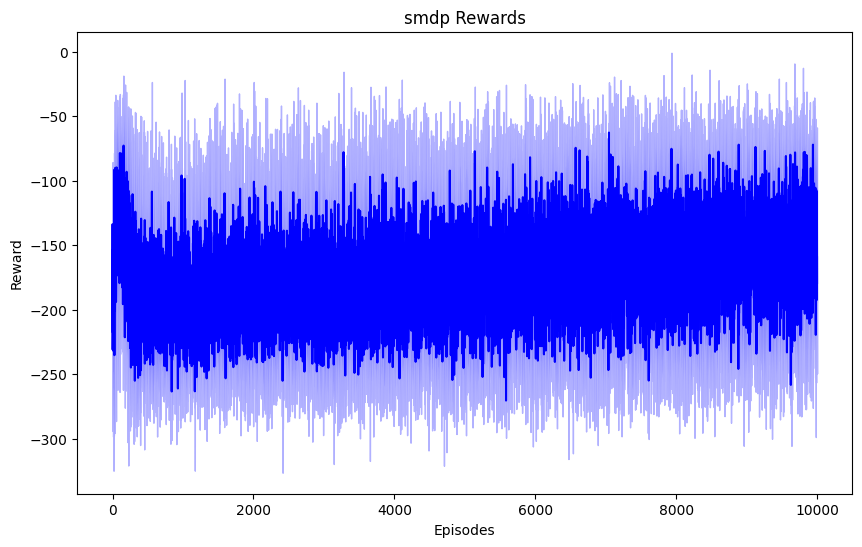

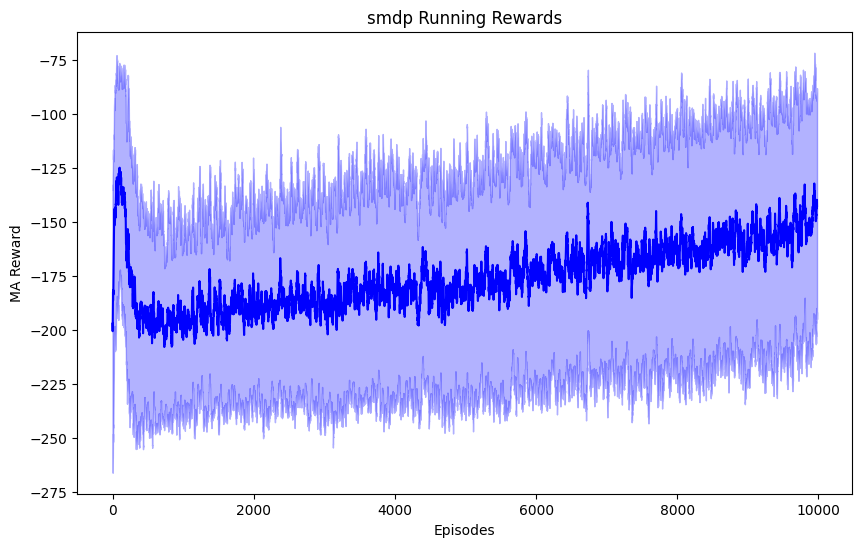

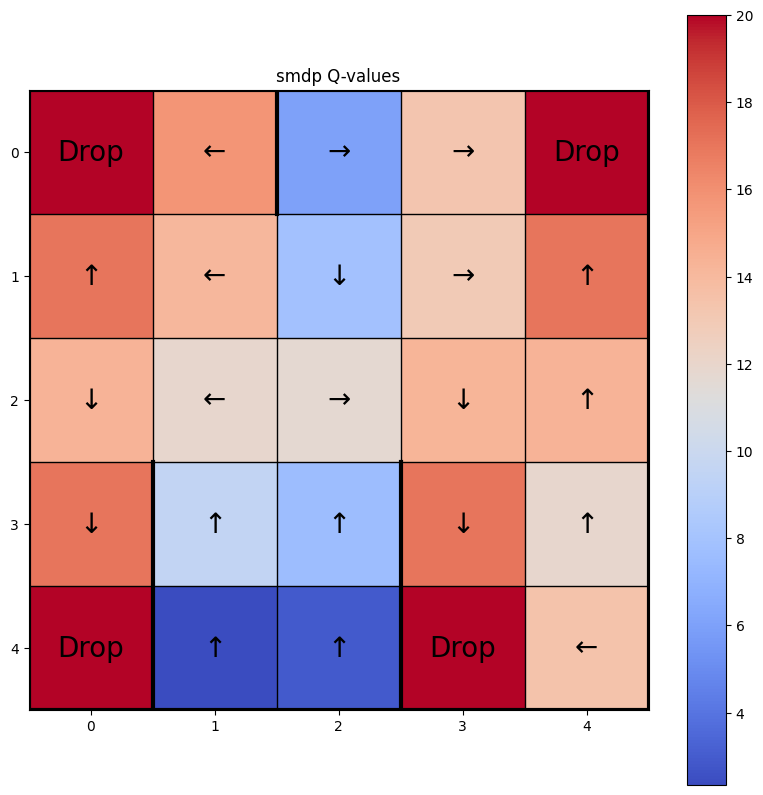

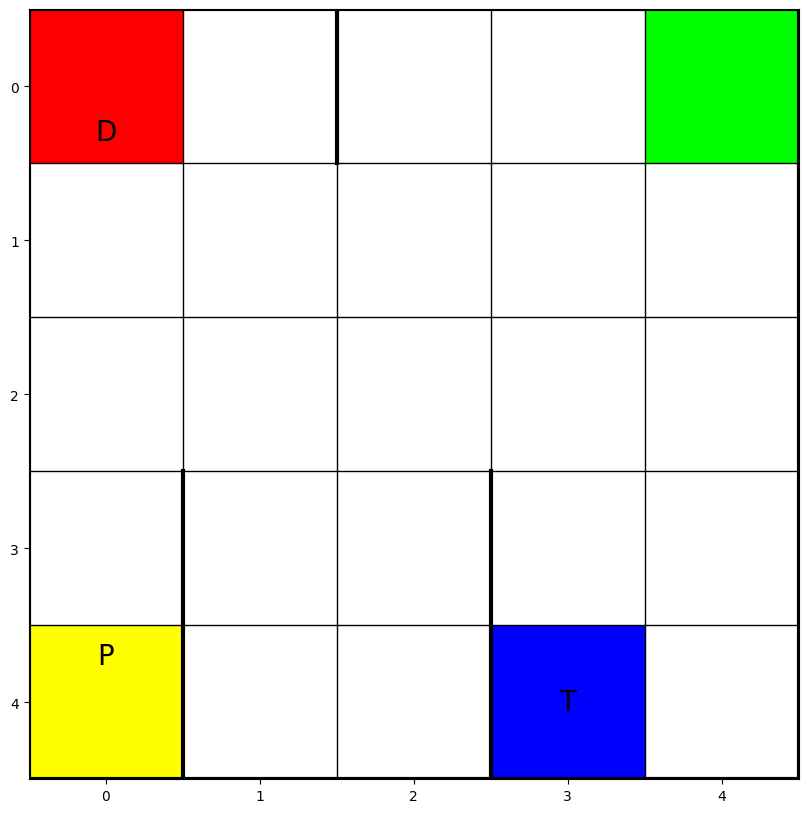

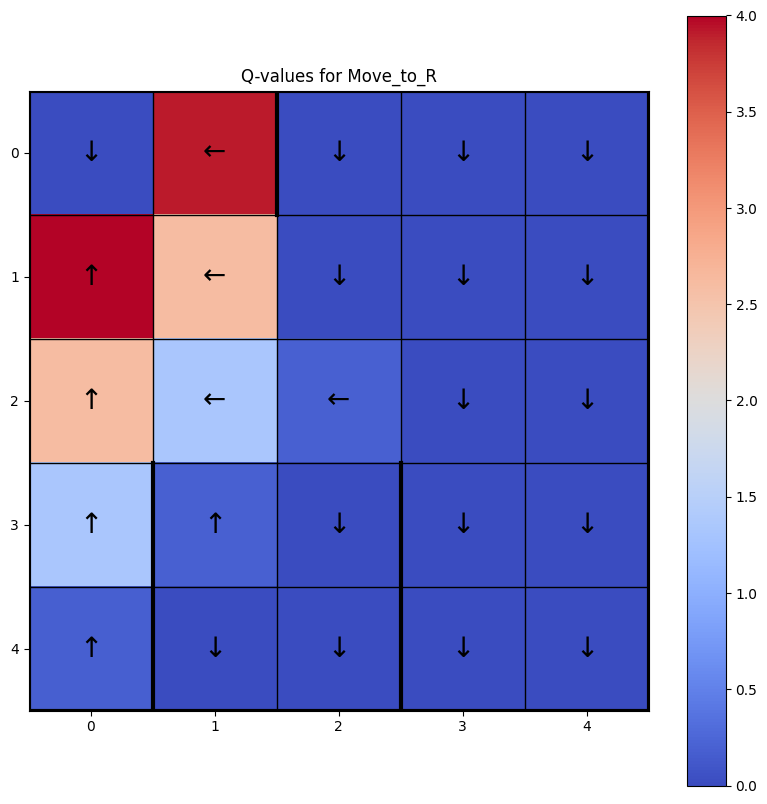

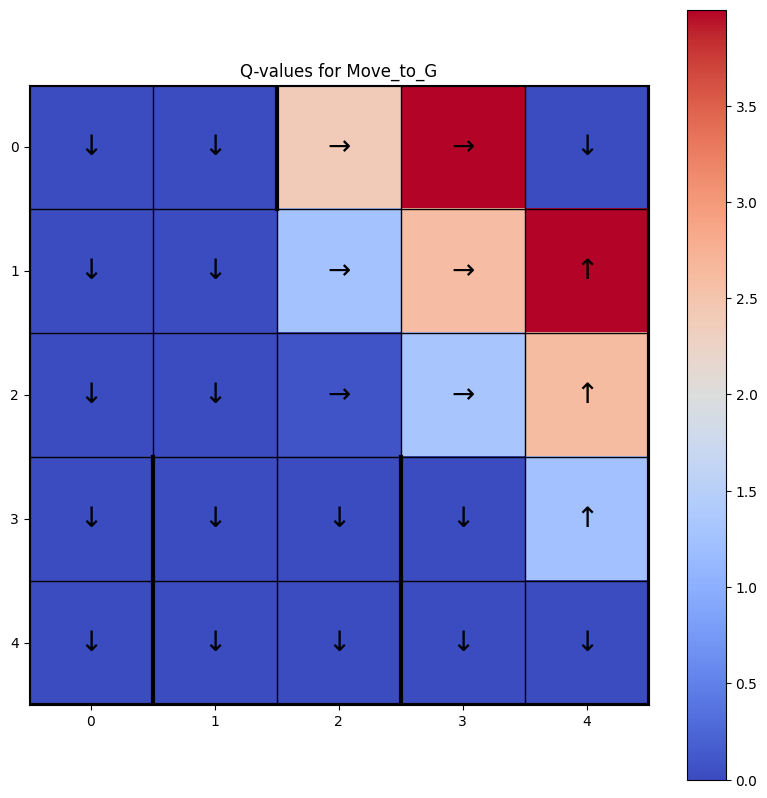

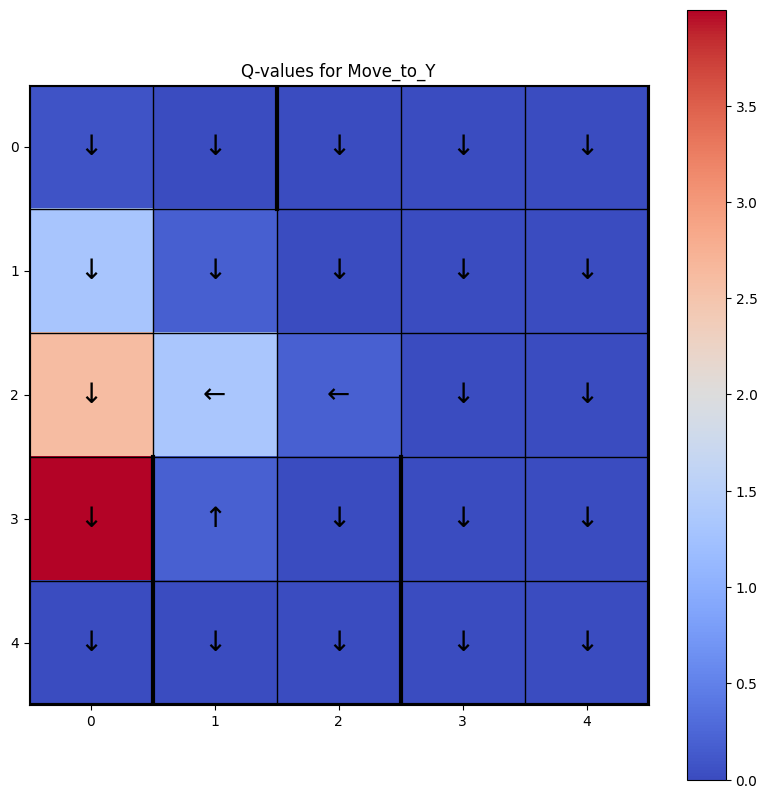

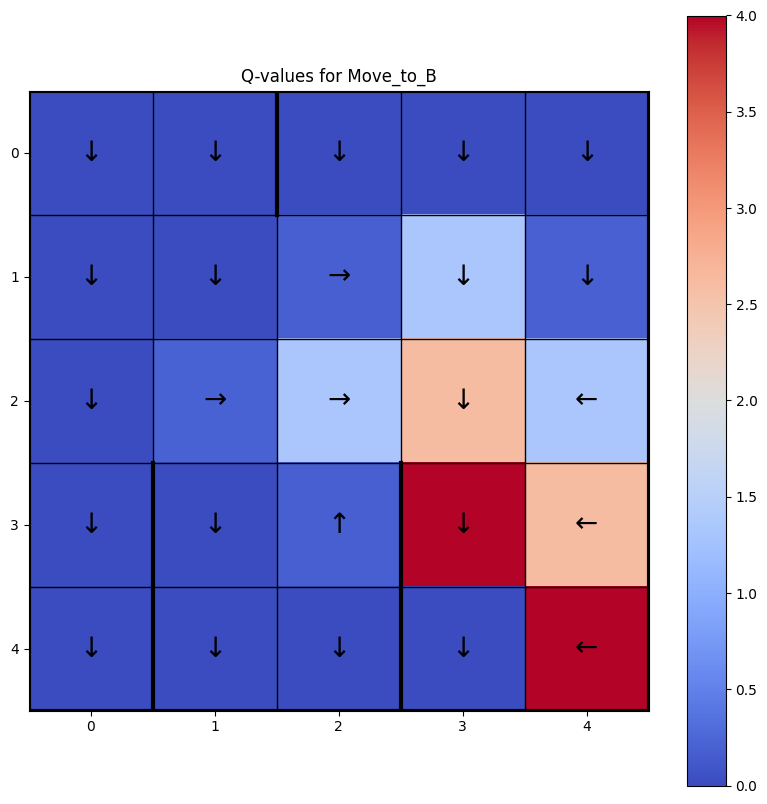

In [98]:
# Implement SMDP Q-Learning
# args = Args()
# trainer = Trainer(env, options, args, algo="smdp")
# Q, rewards = trainer.train()
# np.save("results/smdp_Q.npy", Q)
# np.save("results/smdp_rewards.npy", rewards)

Q = np.load("results/smdp_Q.npy")
rewards = np.load("results/smdp_rewards.npy")

plot = Plot(env, rewards, Q, "smdp")
plot.plot_rewards()
plot.plot_running_rewards()
plot.plot_Q()
plot.visualize_taxi_env()

# Plot Q-Table of options
for i, option in enumerate(trainer.options):
    plot_Q(option.q_values, f"Q-values for {option.name}")

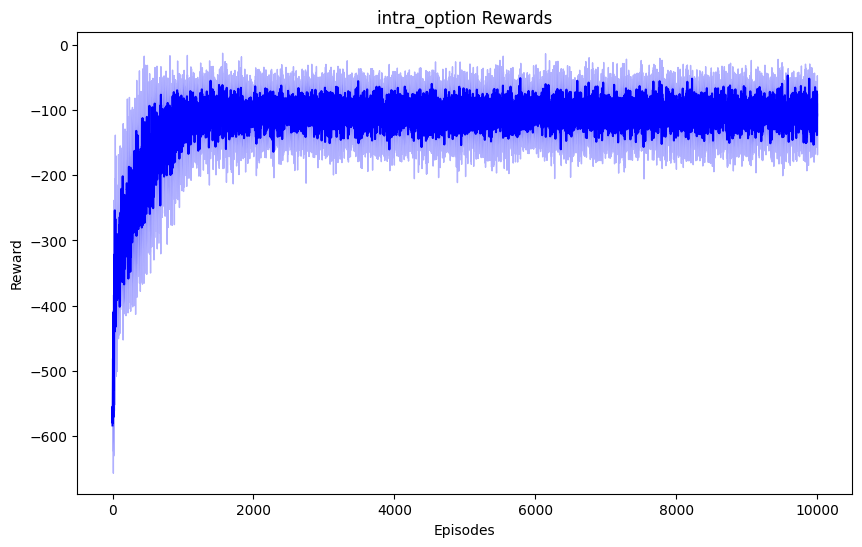

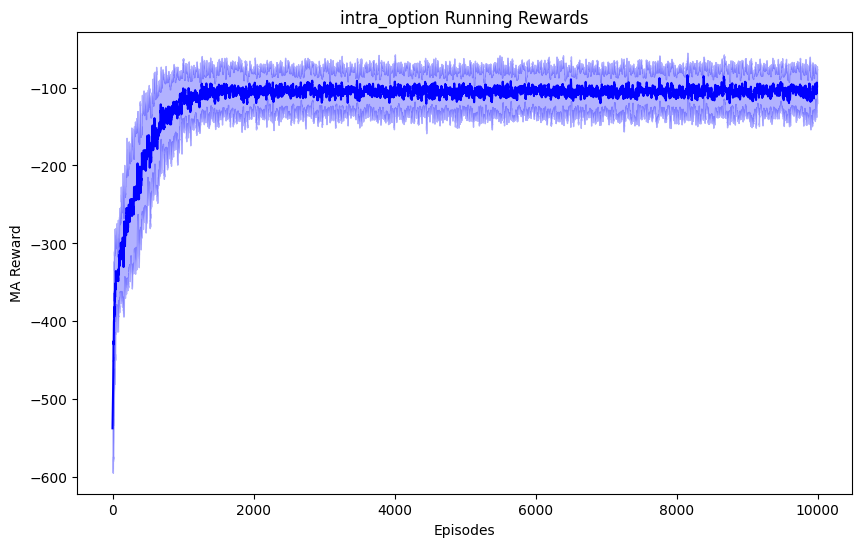

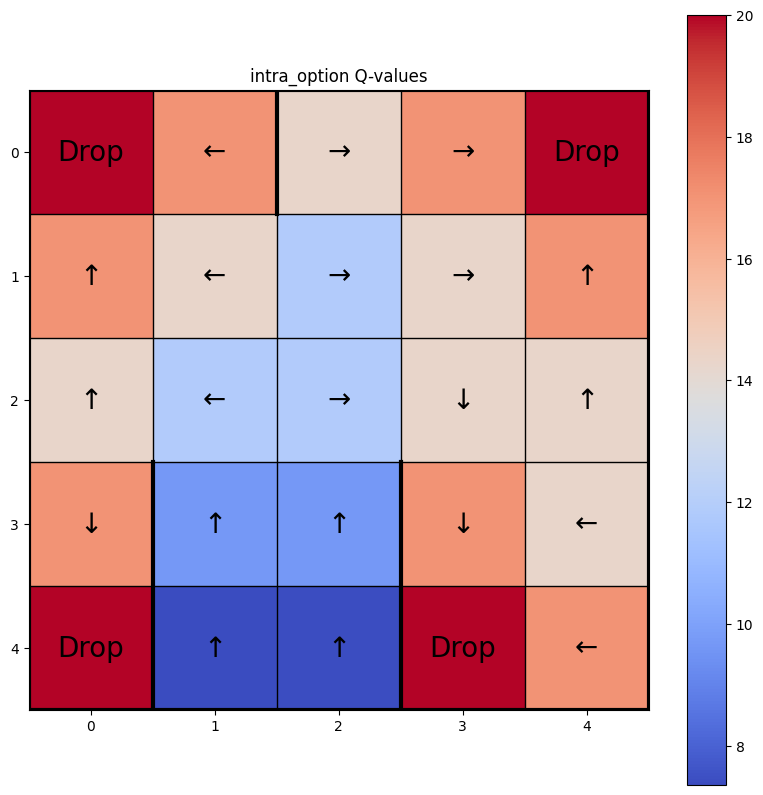

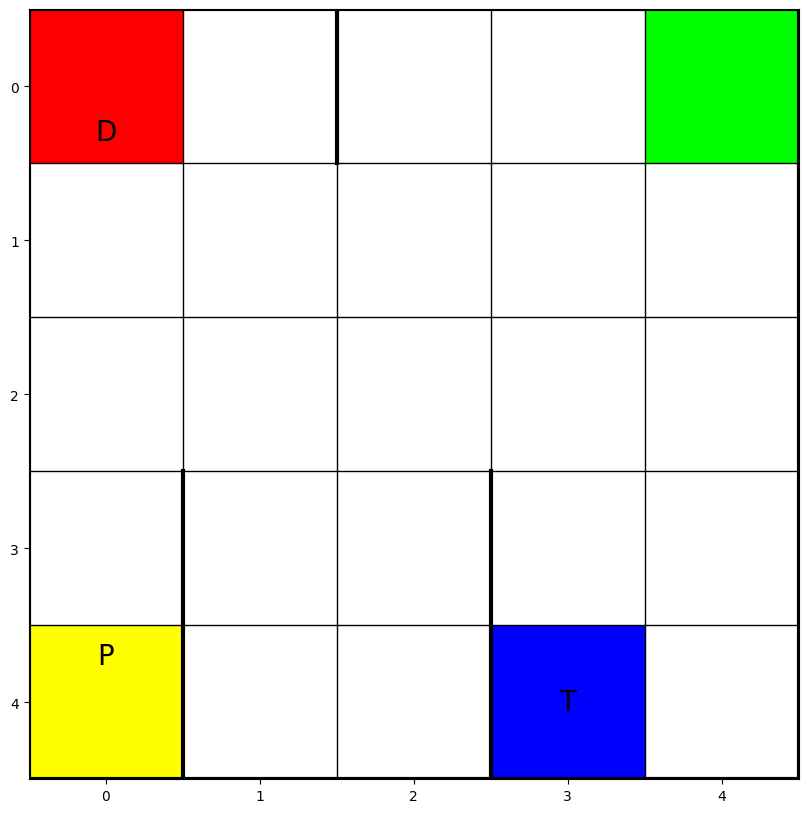

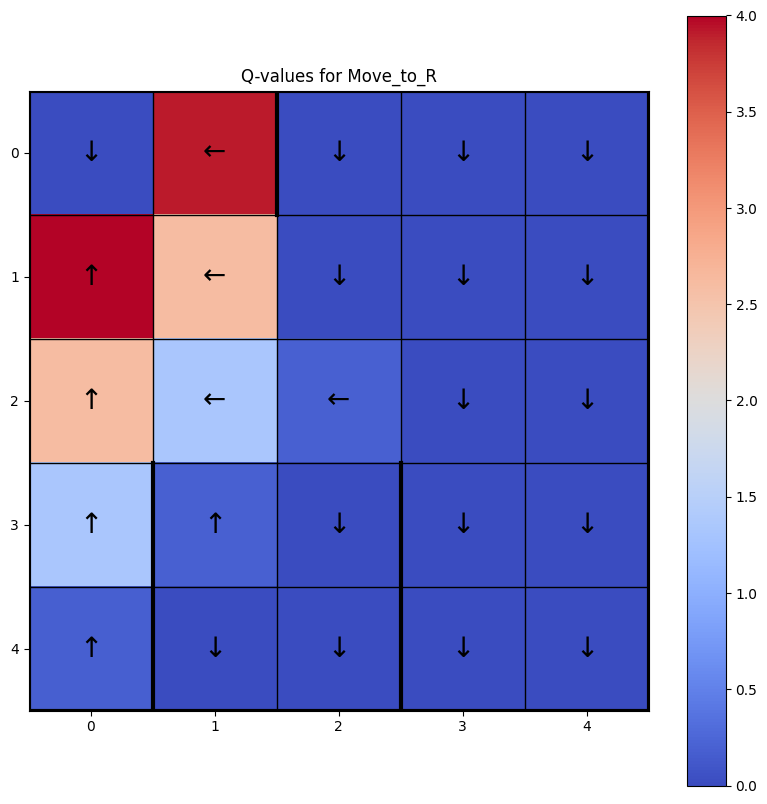

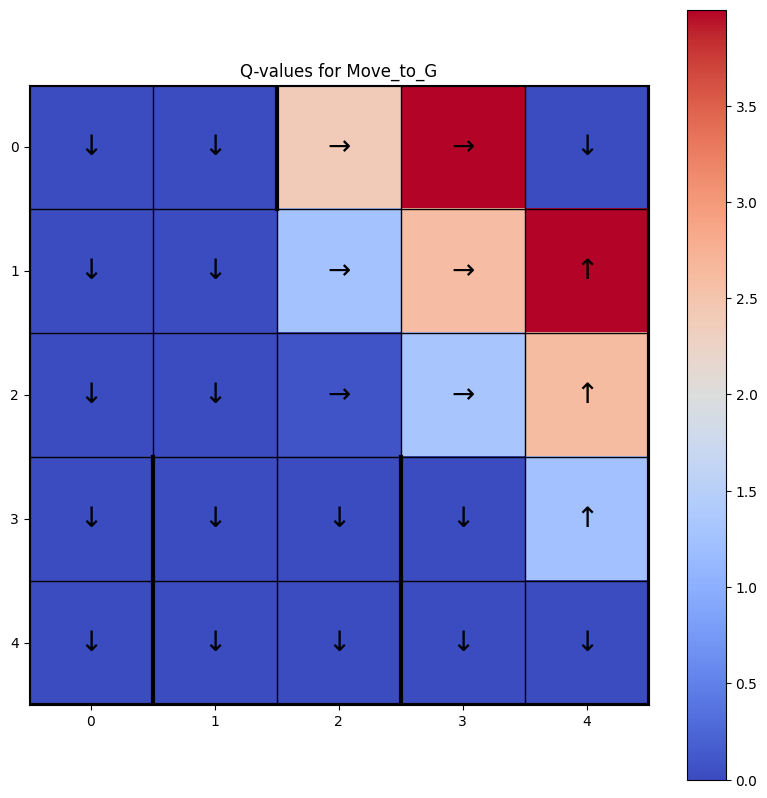

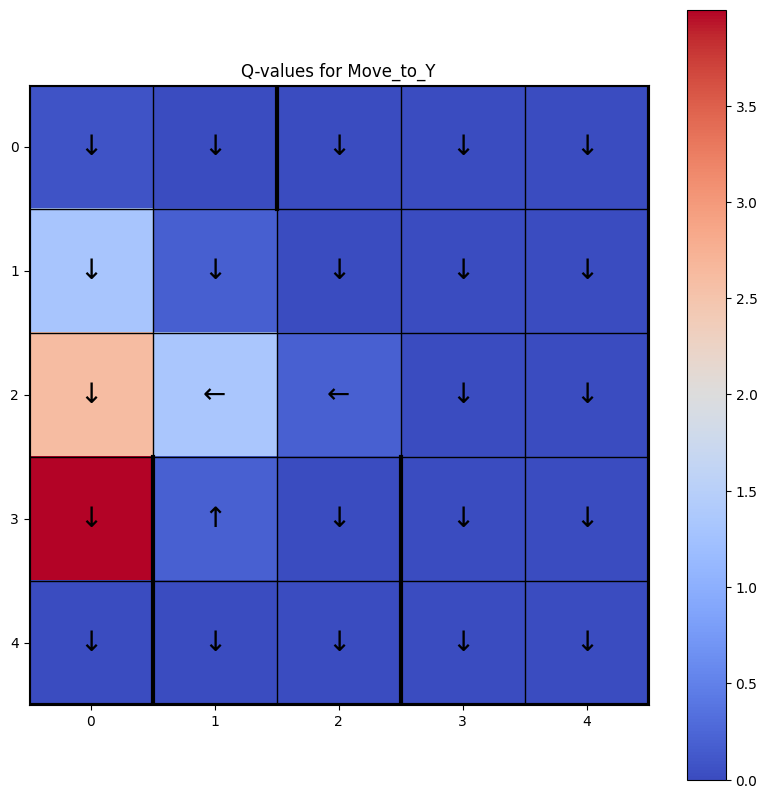

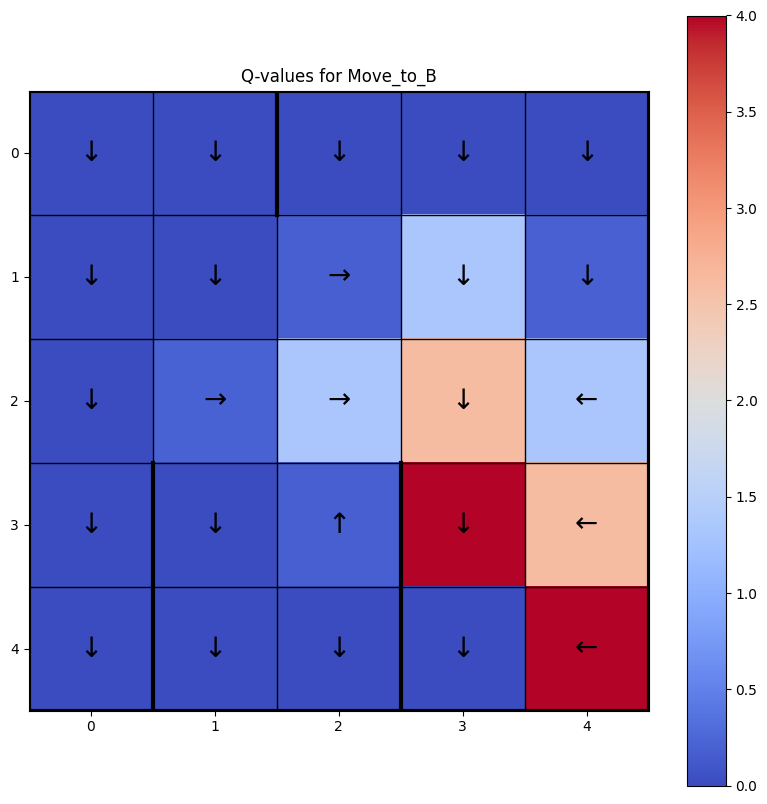

In [95]:
# Implement Intra Option Q-Learning
# args = Args()
# trainer = Trainer(env, options, args, algo="intra_option")
# Q, rewards = trainer.train()
# np.save("results/intra_option.npy", Q)
# np.save("results/intra_option_q_learning_rewards.npy", rewards)

Q = np.load("results/intra_option.npy")
rewards = np.load("results/intra_option_q_learning_rewards.npy")

plot = Plot(env, rewards, Q, "intra_option")
plot.plot_rewards()
plot.plot_running_rewards()
plot.plot_Q()
plot.visualize_taxi_env()

# Plot Q-Table of options
for i, option in enumerate(trainer.options):
    plot_Q(option.q_values, f"Q-values for {option.name}")

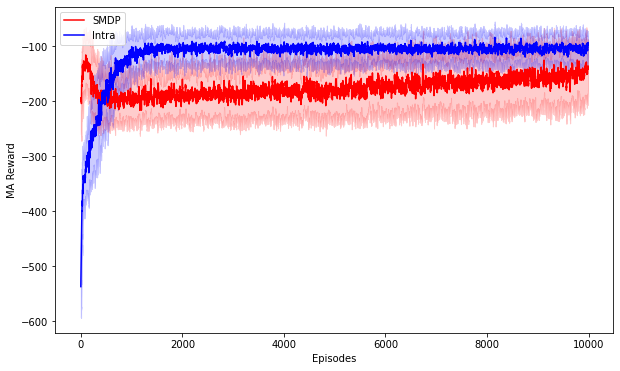

In [12]:
def plot_running_rewards_together(r1, r2):
    plt.figure(figsize=(10, 6))
    window = 10
    running_rewards1 = moving_average(r1.mean(axis=0), window)
    plt.plot(running_rewards1, color='red', label="SMDP")
    fill_std1 = moving_average(r1.std(axis=0), window)
    plt.fill_between(range(len(running_rewards1)), running_rewards1 - fill_std1, running_rewards1 + fill_std1, alpha=0.2, color='red')
    running_rewards2 = moving_average(r2.mean(axis=0), window)
    plt.plot(running_rewards2, color='blue', label="Intra")
    fill_std2 = moving_average(r2.std(axis=0), window)
    plt.fill_between(range(len(running_rewards2)), running_rewards2 - fill_std2, running_rewards2 + fill_std2, alpha=0.2, color='blue')

    plt.xlabel("Episodes")
    plt.ylabel("MA Reward")
    plt.legend()
    # plt.grid()
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

rewards_smdp = np.load("results/smdp_rewards.npy")
rewards_io = np.load("results/intra_option_q_learning_rewards.npy")
plot_running_rewards_together(rewards_smdp, rewards_io)

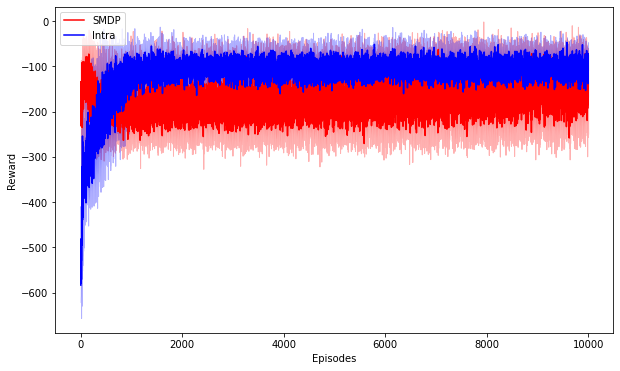

In [8]:
def plot_together(r1, r2):
    plt.figure(figsize=(10, 6))
    plt.plot(r1.mean(axis=0), color='red', label="SMDP")
    plt.fill_between(range(r1.shape[1]), r1.mean(axis=0) - r1.std(axis=0), r1.mean(axis=0) + r1.std(axis=0), alpha=0.3, color='red')
    plt.plot(r2.mean(axis=0), color='blue', label="Intra")
    plt.fill_between(range(r2.shape[1]), r2.mean(axis=0) - r2.std(axis=0), r2.mean(axis=0) + r2.std(axis=0), alpha=0.3, color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.legend()
    # plt.grid()
    plt.show()

rewards_smdp = np.load("results/smdp_rewards.npy")
rewards_io = np.load("results/intra_option_q_learning_rewards.npy")
plot_together(rewards_smdp, rewards_io)

In [ ]:
for idx in range(20):
    state = idx * 20
    Q_grid = np.zeros((5, 5, 6))
    for row in range(5):
        for col in range(5):
            for action in range(6):
                Q_grid[row, col, action] = Q[state + row * 5 + col][action]
    plt.figure(figsize=(10, 10))
    plt.imshow(Q_grid.max(axis=2), cmap='coolwarm')

    # Add annotations
    for i in range(5):
        for j in range(5):
            action = np.argmax(Q_grid[i, j])
            if action == 0: # put down arrow
                plt.text(j, i, u'\u2193', color='black', fontsize=20, ha='center', va='center')
            elif action == 1: # put up arrow
                plt.text(j, i, u'\u2191', color='black', fontsize=20, ha='center', va='center')
            elif action == 2: # put right arrow
                plt.text(j, i, u'\u2192', color='black', fontsize=20, ha='center', va='center')
            elif action == 3: # put left arrow
                plt.text(j, i, u'\u2190', color='black', fontsize=20, ha='center', va='center')
            elif action == 4: # put Pick
                plt.text(j, i, "Pick", color='black', fontsize=20, ha='center', va='center')
            elif action == 5: # put Drop
                plt.text(j, i, "Drop", color='black', fontsize=20, ha='center', va='center')

    plt.axhline(y=-0.5, color='black', linewidth=3)
    plt.axhline(y=4.5, color='black', linewidth=3)
    plt.axvline(x=-0.5, color='black', linewidth=3)
    plt.axvline(x=4.5, color='black', linewidth=3)

    # Add horizontal grid lines
    for i in range(6):
        plt.axhline(y=i-0.5, color='black', linewidth=1)

    # Add vertical grid lines
    for i in range(6):
        plt.axvline(x=i-0.5, color='black', linewidth=1)

    plt.axvline(x=1.5, ymin=0.8, ymax=1, color='black', linewidth=3)
    plt.axvline(x=0.5, ymin=0, ymax=0.4, color='black', linewidth=3)
    plt.axvline(x=2.5, ymin=0, ymax=0.4, color='black', linewidth=3)

    plt.colorbar()
    plt.title(f"Q-values for state {idx}")
    plt.show()